In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [4]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 17.4 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=0c5438f43a39838c299a3be3470acd12246bc241d1275a9b50728ee13ed7684f
  Stored in directory: /root/.cache/pip/wheels/de/07/2e/814a6ee82e37528f2044a609a431028375b149bc31f03c0e27
Successfully built umap-learn


In [25]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.stem import SnowballStemmer
from plotly import express as px
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from umap import UMAP

In [7]:
kaggle = False

In [8]:
filepath = 'data/reviews.csv' if not kaggle else './kaggle/input/consumer-review-of-clothing-product/Consumer Review of Clothing Product/data_amazon.xlsx - Sheet1.csv'

exported_df = pd.read_csv(filepath)

display(exported_df)

,Unnamed: 0,Title,Review,Cons_rating,Cloth_class
0,2,Some major design flaws,I had such high hopes for this dress and reall...,3.0,Dresses
1,3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,Pants
2,4,Flattering shirt,This shirt is very flattering to all due to th...,5.0,Blouses
3,5,Not for the very petite,"I love tracy reese dresses, but this one is no...",2.0,Dresses
4,6,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5.0,Knits
...,...,...,...,...,...
45303,49333,Dress felt and fit great. I got lots of compl...,Loved the color!!! Dress fit great and I got ...,5.0,Dresses
45304,49334,Loved the dress but poor quality,This dress looked great and I loved the materi...,2.0,Dresses
45305,49335,"Cute dress, didn't fit",Wanted this dress to work it didn't. It is ver...,1.0,Dresses
45306,49336,Very cute!,No complaints othe than the zipper gets stuck ...,4.0,Dresses


In [9]:
stemmer = SnowballStemmer('english')

In [10]:
def text_feature_extract(text_feature, model):
    text = model.fit_transform(text_feature)
        
    return text

In [11]:
word_features = exported_df['Review']

words = "".join(word for word in word_features.values)

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
languages = {'english', 'spanish', 'portuguese', 'italian'}

stopwords = list()

for lang in languages:
    stopwords.extend(nltk.corpus.stopwords.words(lang))

In [16]:
stemmed = word_features.str.split().apply(lambda x: [stemmer.stem(y) for y in x])

stemmed = stemmed.apply(lambda x: ' '.join(x))

In [17]:
tfidf_vect = TfidfVectorizer(stop_words = stopwords, min_df = 3, max_df = 8000)

text_all = text_feature_extract(stemmed, tfidf_vect)

In [18]:
print(f"Number of words = {len(tfidf_vect.get_feature_names_out())}")

Number of words = 7608


In [19]:
target_classes = list(exported_df['Cloth_class'].unique())

targets = exported_df['Cloth_class']

class_map = {cloth_class: target_classes.index(cloth_class) for cloth_class in target_classes} 

In [20]:
X = text_all 
y = targets.map(class_map)

In [21]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 1, test_size = 0.4, stratify = y)

In [22]:
def model_results(model, model_name, train_X, test_X, train_y, test_y):
    model.fit(train_X, train_y)
    
    train_pred = model.predict(train_X)
    test_pred = model.predict(test_X)
    train_prob = model.predict_proba(train_X)
    test_prob = model.predict_proba(test_X)
    
def plot_confusion_matrix(cnf_matrix, target_classes):
    fig, ax = plt.subplots(figsize = (15,15))
    
    sns.heatmap(cnf_matrix, 
                xticklabels = target_classes, 
                yticklabels = target_classes, 
                annot = True,
                cmap = 'viridis',
                fmt = "d"
               ).set(xlabel = 'Predicted class', ylabel = 'True class')
    
    plt.show()

In [23]:
reducer = TruncatedSVD(n_components = 800)#UMAP(n_components = 70, metric = 'cosine', random_state = 1)

log_reg = LogisticRegression(max_iter = 8000, n_jobs = 4, C = 1)

log_reg_pipe = Pipeline([
                ('reduction', reducer), 
                ('logistic_regression', log_reg)
               ])

In [24]:
%%time 

log_reg.fit(train_X, train_y)

CPU times: user 35.8 ms, sys: 88.1 ms, total: 124 ms
Wall time: 6.5 s


LogisticRegression(C=1, max_iter=8000, n_jobs=4)

In [178]:
log_reg0_preds = {'train': log_reg.predict(train_X),
                  'test': log_reg.predict(test_X),
                  'prob_train': log_reg.predict_proba(train_X),
                  'prob_test': log_reg.predict_proba(test_X),
                 }

In [179]:
print(f'Logistic Regression train accuracy score = {accuracy_score(train_y, log_reg0_preds["train"])}')
print(f'Logistic Regression test accuracy score = {accuracy_score(test_y, log_reg0_preds["test"])}')

Logistic Regression train accuracy score = 0.7078428487345497
Logistic Regression test accuracy score = 0.5886669609357758


In [180]:
print(f'Logistic Regression train roc auc score = {roc_auc_score(train_y, log_reg0_preds["prob_train"], multi_class = "ovo")}')
print(f'Logistic Regression test roc auc score = {roc_auc_score(test_y, log_reg0_preds["prob_test"], multi_class = "ovo")}')

Logistic Regression train roc auc score = 0.9471567482649336
Logistic Regression test roc auc score = 0.9034680214223717


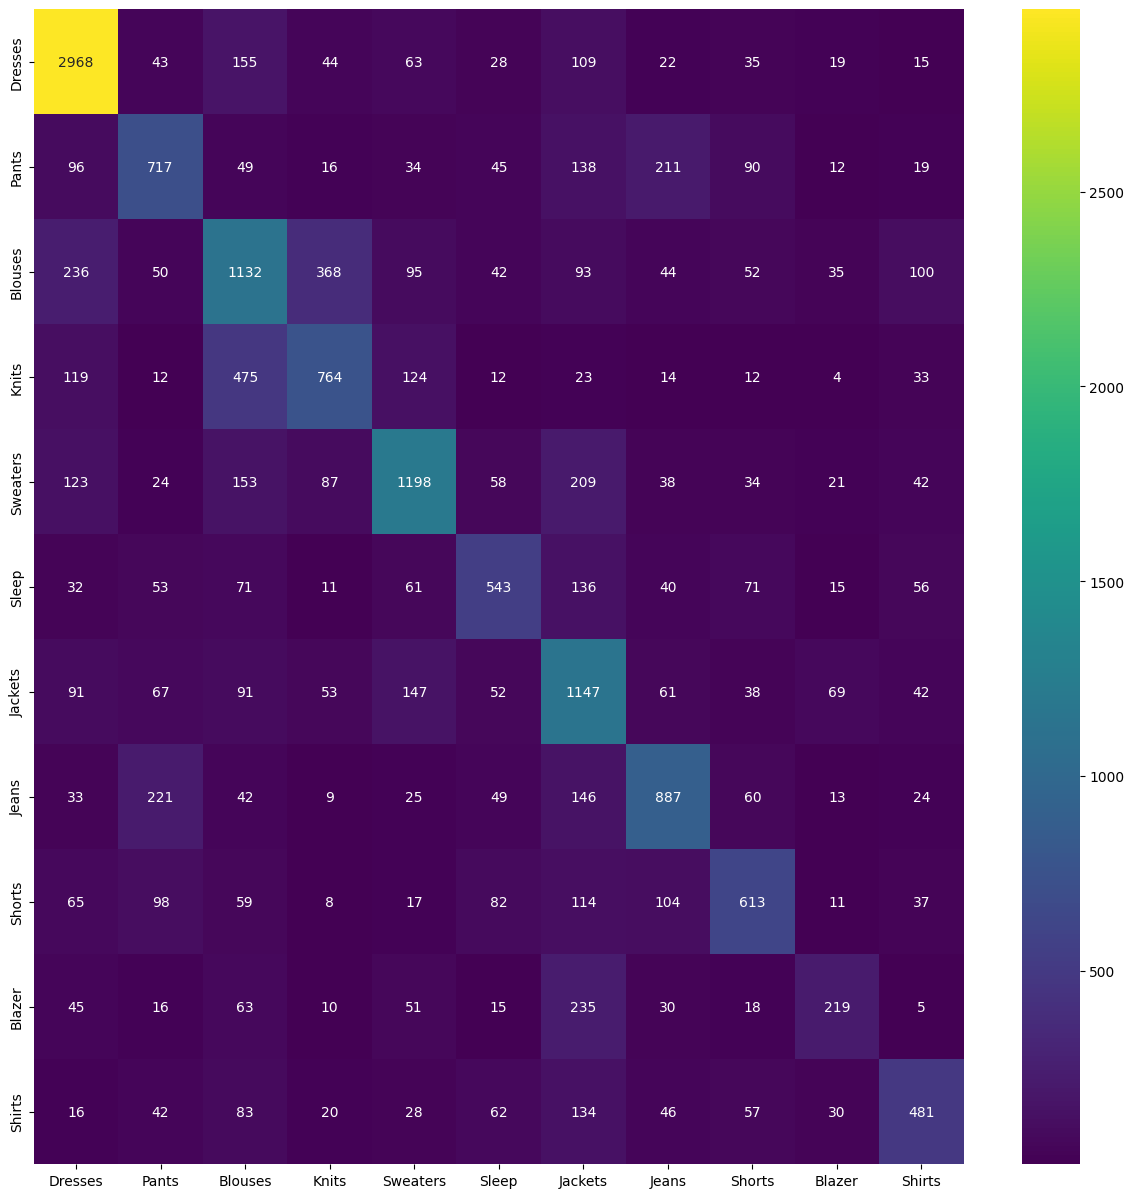

In [181]:
plot_confusion_matrix(confusion_matrix(test_y, log_reg0_preds["test"]), target_classes)

In [169]:
%%time 

log_reg_pipe.fit(train_X, train_y)

CPU times: user 38.5 s, sys: 10.9 s, total: 49.4 s
Wall time: 41.8 s


Pipeline(steps=[('reduction', TruncatedSVD(n_components=800)),
                ('logistic_regression',
                 LogisticRegression(C=1, max_iter=8000, n_jobs=4))])

In [170]:
log_reg_preds = {'train': log_reg_pipe.predict(train_X),
                 'test': log_reg_pipe.predict(test_X),
                 'prob_train': log_reg_pipe.predict_proba(train_X),
                 'prob_test': log_reg_pipe.predict_proba(test_X),
                }

In [171]:
print(f'Logistic Regression train accuracy score = {accuracy_score(train_y, log_reg_preds["train"])}')
print(f'Logistic Regression test accuracy score = {accuracy_score(test_y, log_reg_preds["test"])}')

Logistic Regression train accuracy score = 0.6344908769864627
Logistic Regression test accuracy score = 0.5755352019421761


In [172]:
print(f'Logistic Regression train roc auc score = {roc_auc_score(train_y, log_reg_preds["prob_train"], multi_class = "ovo")}')
print(f'Logistic Regression test roc auc score = {roc_auc_score(test_y, log_reg_preds["prob_test"], multi_class = "ovo")}')

Logistic Regression train roc auc score = 0.9254563113021507
Logistic Regression test roc auc score = 0.8995608233003317


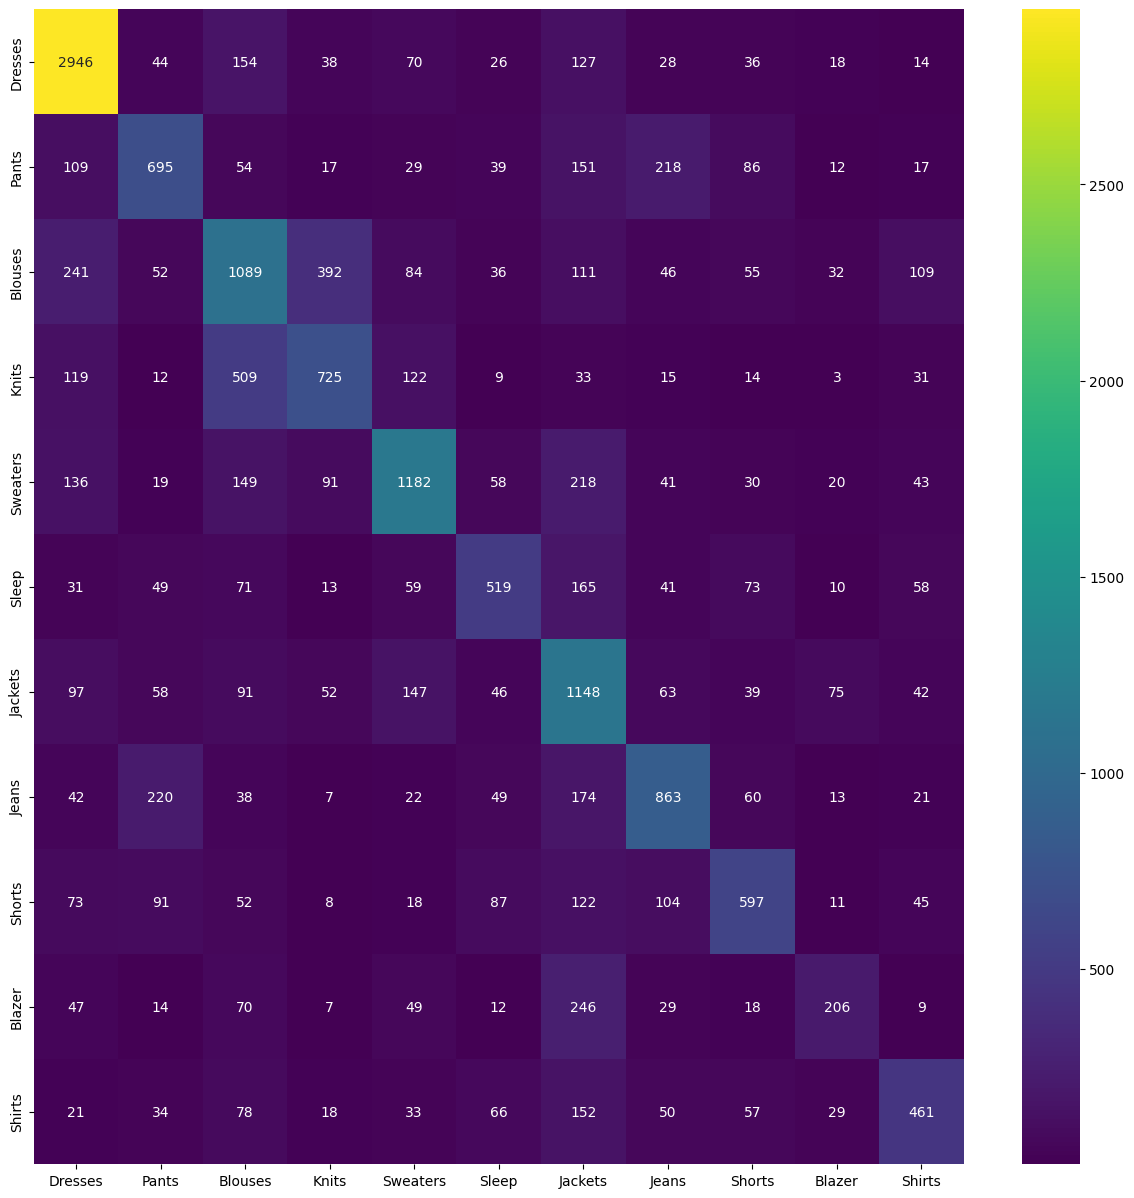

In [173]:
plot_confusion_matrix(confusion_matrix(test_y, log_reg_preds["test"]), target_classes)

In [154]:
reducer = PCA(n_components = 100)#UMAP(n_components = 70, metric = 'cosine', random_state = 1)

svc = SVC(C = 10, gamma = 0.01, probability = True)

svc_pipe = Pipeline([
                ('reduction', reducer), 
                ('svc', svc)
           ])

In [157]:
%%time 

svc_pipe.fit(train_X.toarray(), train_y)

CPU times: user 9min, sys: 10.7 s, total: 9min 10s
Wall time: 8min 3s


Pipeline(steps=[('reduction', PCA(n_components=100)),
                ('svc', SVC(C=10, gamma=0.01, probability=True))])

In [ ]:
svc_preds = {'train': svc_pipe.predict(train_X),
             'test': svc_pipe.predict(test_X),
             'prob_train': svc_pipe.predict_proba(train_X),
             'prob_test': svc_pipe.predict_proba(test_X),
            }

In [158]:
svc_preds = {'train': svc_pipe.predict(train_X.toarray()),
             'test': svc_pipe.predict(test_X.toarray()),
             'prob_train': svc_pipe.predict_proba(train_X.toarray()),
             'prob_test': svc_pipe.predict_proba(test_X.toarray()),
            }

In [159]:
print(f'SVC train accuracy score = {accuracy_score(train_y, svc_preds["train"])}')
print(f'SVC test accuracy score = {accuracy_score(test_y, svc_preds["test"])}')

SVC train accuracy score = 0.4996321365509123
SVC test accuracy score = 0.4939306996248069


In [160]:
print(f'SVC train roc auc score = {roc_auc_score(train_y, svc_preds["prob_train"], multi_class = "ovo")}')
print(f'SVC test roc auc score = {roc_auc_score(test_y, svc_preds["prob_test"], multi_class = "ovo")}')

SVC train roc auc score = 0.8718624268012551
SVC test roc auc score = 0.861987215629764


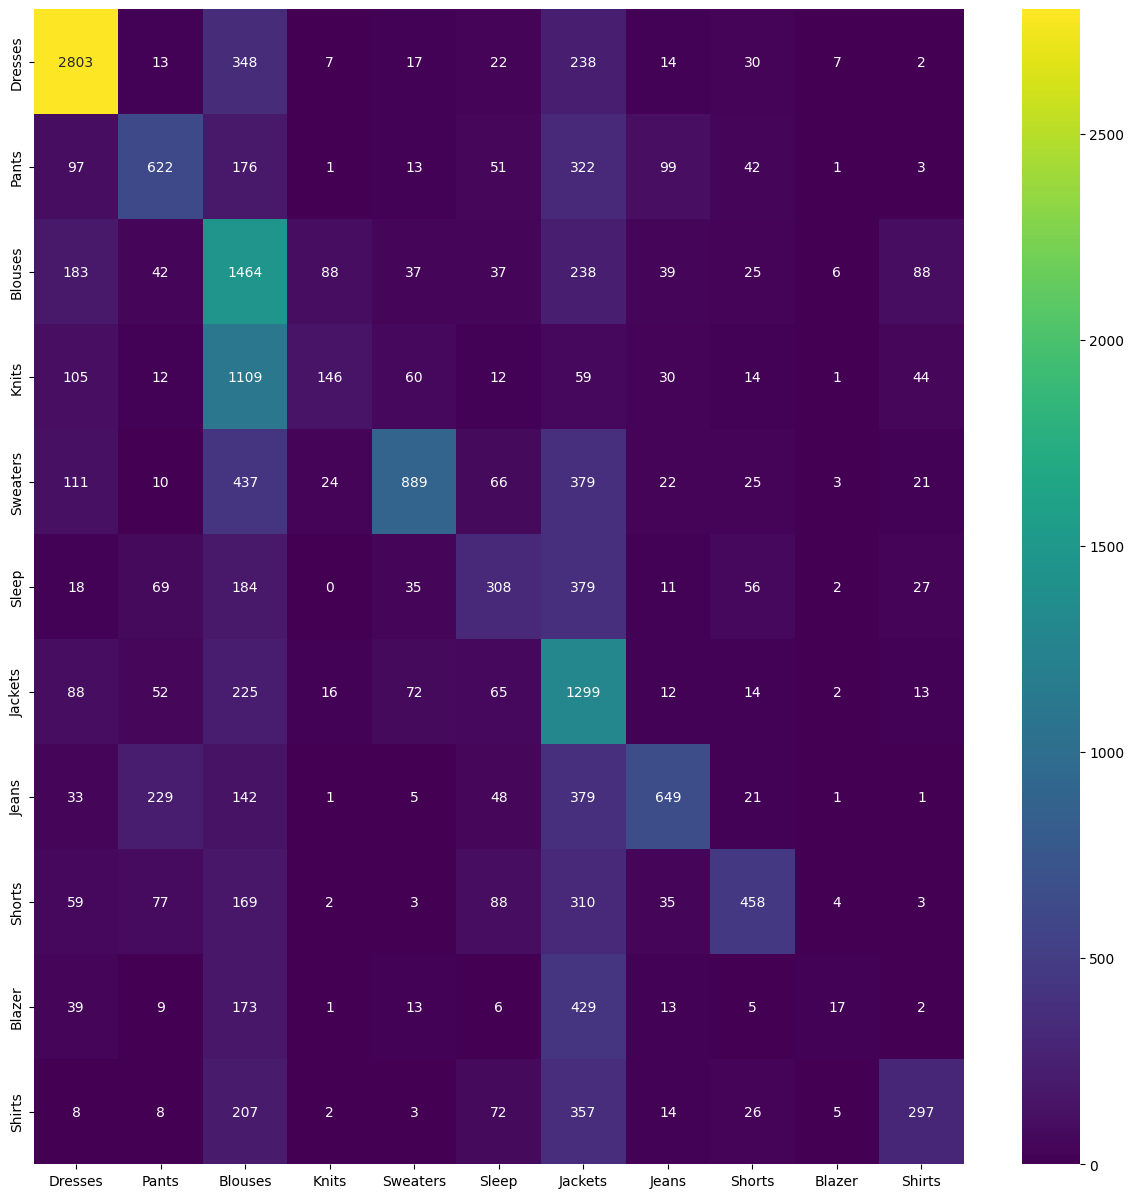

In [161]:
plot_confusion_matrix(confusion_matrix(test_y, svc_preds["test"]), target_classes)

In [33]:
reducer = UMAP(n_components = 404, metric = 'cosine', random_state = 1)

forest = RandomForestClassifier(n_jobs = 4, random_state = 1, max_leaf_nodes = 454, n_estimators = 794)

forest_pipe = Pipeline([
                ('reduction', reducer), 
                ('random_forest', forest)
              ])

In [ ]:
%%time

forest_pipe.fit(train_X, train_y)

In [ ]:
forest_preds = {'train': forest_pipe.predict(train_X),
                'test': forest_pipe.predict(test_X),
                'prob_train': forest_pipe.predict_proba(train_X),
                'prob_test': forest_pipe.predict_proba(test_X),
               }

In [ ]:
print(f'Random Forest train accuracy score = {accuracy_score(train_y, forest_preds["train"])}')
print(f'Random Forest test accuracy score = {accuracy_score(test_y, forest_preds["test"])}')

In [ ]:
print(f'Random Forest train roc auc score = {roc_auc_score(train_y, forest_preds["prob_train"], multi_class = "ovo")}')
print(f'Random Forest test roc auc score = {roc_auc_score(test_y, forest_preds["prob_test"], multi_class = "ovo")}')

In [ ]:
plot_confusion_matrix(confusion_matrix(test_y, forest_preds["test"]), target_classes)

In [30]:
cv = StratifiedKFold(n_splits = 4)

scoring = make_scorer(roc_auc_score, multi_class='ovo', needs_proba = True)

forest_scores = cross_val_score(forest, X, y, cv = cv, n_jobs = 4, scoring = scoring)

In [32]:
print(f'Random Forest cross validation scores = {forest_scores}')
print(f'Random Forest mean cross validation score = {forest_scores.mean()}')

Random Forest cross validation scores = [0.87598541 0.8975818  0.88000215 0.85699833]
Random Forest mean cross validation score = 0.8776419210269824


In [36]:
reducer = UMAP(n_components = 1004, metric = 'cosine', random_state = 1)

forest = RandomForestClassifier(random_state = 1, max_leaf_nodes = 754, n_estimators = 994)

forest_pipe = Pipeline([
                ('reduction', reducer), 
                ('random_forest', forest)
              ])

In [ ]:
%%time

cv = StratifiedKFold(n_splits = 4)

scoring = make_scorer(roc_auc_score, multi_class='ovo', needs_proba = True)

forest_scores = cross_val_score(forest_pipe, X, y, cv = cv, n_jobs = 4, scoring = scoring)

2023-12-02 22:53:02.168618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 22:53:02.168618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 22:53:02.168645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 22:53:02.168654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 22:53:02.178460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory f

In [ ]:
print(f'Random Forest cross validation scores = {forest_scores}')
print(f'Random Forest mean cross validation score = {forest_scores.mean()}')